In [7]:
%matplotlib inline

# Enable Retina mode for higher-res on Macbook's with Retina Display
%config InlineBackend.figure_format = 'retina'

In [8]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.sql.types import *

In [9]:
itemsDF = sqlContext.read.format("json") \
            .load("file:/root/pipeline/myapps/html/advancedspark.com/json/software.json") \
            .select("id", "title", "category", "description")

In [10]:
import pyspark.sql.functions as func

categoriesDF = itemsDF.select("category") \
                 .groupBy("category") \
                 .count() \
                 .orderBy("count", ascending=False) \
                 .filter("count > 10") \
                 .toPandas()

categoriesDF

category  count
0          Library     15
1         Database     12
2  Data Processing     11

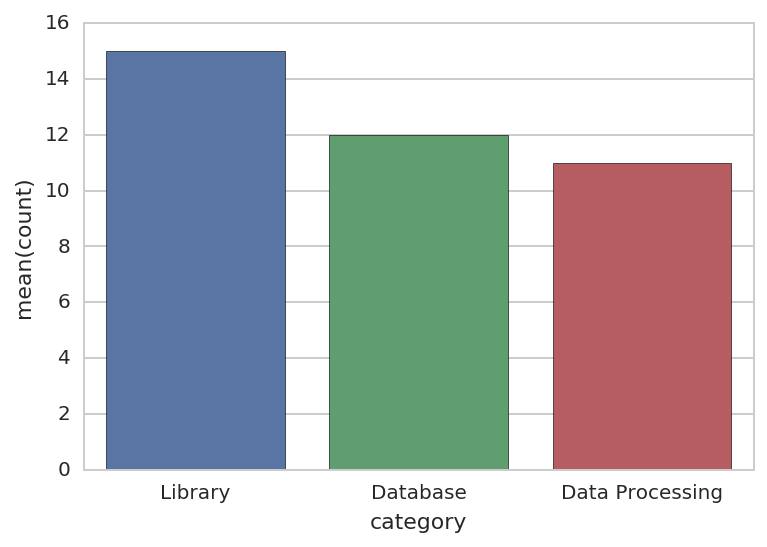

In [11]:
sns.set_style("whitegrid")
plot = sns.barplot(x="category", y="count", data=categoriesDF)

In [12]:
from pyspark.ml.feature import RegexTokenizer

tokenizer = RegexTokenizer(inputCol = "description", \
                           outputCol="words", \
                           gaps=False, \
                           pattern="\\p{L}+")
tokenizer

RegexTokenizer_4439933bd4ef7403204c

In [13]:
from pyspark.ml.feature import StopWordsRemover

stopWordsFilter = StopWordsRemover(inputCol = "words", \
                                   outputCol = "filteredWords", \
                                   caseSensitive = False)
stopWordsFilter

StopWordsRemover_4faea7e280897f34b3d2

In [14]:
from pyspark.ml.feature import HashingTF

tf = HashingTF(inputCol = "filteredWords", \
               outputCol = "tfFeatures")
                                   
tf

HashingTF_4b6994db6db7b04e3430

In [15]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol = "tfFeatures", \
          outputCol = "idfFeatures")
                                   
idf

IDF_47babfc558a0f0f5246c

In [16]:
from pyspark.ml.feature import StringIndexer

categoryIndexer = StringIndexer(inputCol = "category", \
                                outputCol = "indexedCategory") 

categoryIndexerModel = categoryIndexer.fit(itemsDF)

categoryIndexerModel

StringIndexer_4631bd89d7136ad6f305

In [17]:
from pyspark.ml.classification import DecisionTreeClassifier

classifier = DecisionTreeClassifier(featuresCol = "idfFeatures", \
                                    labelCol = "indexedCategory", \
                                    predictionCol = "prediction", \
                                    rawPredictionCol = "confidence", \
                                    probabilityCol = "probability")
classifier

DecisionTreeClassifier_4e4f9bd9b031650fc80b

In [18]:
from pyspark.ml.feature import IndexToString

categoryReverseIndexer = IndexToString(inputCol = "prediction", \
                                       outputCol = "predictedCategory", \
                                       labels = categoryIndexerModel.labels)

categoryReverseIndexer

IndexToString_4131a3e22259d800c03f

In [19]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [tokenizer, stopWordsFilter, tf, idf, categoryIndexer, classifier, categoryReverseIndexer])

pipeline

Pipeline_41e8b63fbf695170e27d

In [20]:
# TODO:  Implement Cross Validation and Grid Search

In [21]:
pipelineModel = pipeline.fit(itemsDF)

In [22]:
predictionsDF = pipelineModel.transform(itemsDF)

predictionsDF.select("category", "prediction").toPandas()

category  prediction
0                   Database         1.0
1          Distributed Cache         0.0
2          Cluster Provision         0.0
3                  Container         0.0
4             Cloud Provider         0.0
5            Data Processing         0.0
6            Data Processing         0.0
7                    Library         0.0
8                    Library         0.0
9                File System         0.0
10  Cluster Resource Manager         0.0
11                  Database         0.0
12           Data Processing         0.0
13           Data Processing         0.0
14              Distribution         0.0
15                        UI         0.0
16           Data Processing         0.0
17            Message Broker         0.0
18                   Library         0.0
19             Search Engine         0.0
20             Search Engine         0.0
21                   Library         0.0
22           Data Processing         0.0
23  Cluster Resource Manager         0.0
24               File Format         3.0
25               File Format         3.0
26           Data Processing         0.0
27   Distributed Coordinator         0.0
28                   Library         0.0
29           Data Processing         0.0
..                       ...         ...
50         Distributed Cache         7.0
51               File Format         3.0
52               File Format         3.0
53                  Database         1.0
54            Cloud Provider         0.0
55                        BI         0.0
56                  Workflow         0.0
57                  Database         0.0
58                  Database         1.0
59                   Library         0.0
60                   Library         0.0
61                   Library         0.0
62               File Format         3.0
63                   Library         0.0
64                  Database         0.0
65                   Library         0.0
66                  Database         1.0
67                   Library         0.0
68                  Database         1.0
69           Data Processing         0.0
70                   Library         0.0
71         Distributed Cache         7.0
72                   Library         0.0
73                  Database         1.0
74               File Format         0.0
75               File System         0.0
76           Data Processing         0.0
77                  Database         1.0
78                  Database         0.0
79                  Database         0.0

[80 rows x 2 columns]

## Spark 2.0+ Only!


In [24]:
# Save & load the Random Forest model
pipelineModelPersistPath = "/tmp/spark/2.0.0/dt"
pipelineModel.save(pipelineModelPersistPath)

AttributeError: 'PipelineModel' object has no attribute 'save'

In [25]:
from pyspark.ml import PipelineModel

samePipelineModel = PipelineModel.load(pipelineModelPersistPath)

AttributeError: type object 'PipelineModel' has no attribute 'load'

In [26]:
samePredictionsDF = samePipelineModel.transform(itemsDF)

samePredictionsDF.select("category", "prediction").toPandas()

NameError: name 'samePipelineModel' is not defined